In [16]:
!pip install kerassurgeon
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import load_model
from kerassurgeon import identify 
from kerassurgeon.operations import delete_channels,delete_layer
from kerassurgeon import Surgeon

In [0]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

def normalize(x_train,x_test):
    mean = np.mean(x_train,axis=(0,1,2,3))
    std = np.std(x_train, axis=(0, 1, 2, 3))
    x_train = (x_train-mean)/(std+1e-7)
    x_test = (x_test-mean)/(std+1e-7)
    return x_train, x_test

x_train , x_test = normalize(x_train,x_test)

y_train = np_utils.to_categorical(y_train,10)
y_test = np_utils.to_categorical(y_test,10)


In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()



model_1 = Sequential()

model_1.add(Conv2D(32,(3,3),activation='relu',input_shape=x_train.shape[1:]))

model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(32,(3,3),activation='relu'))

model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(64,(3,3),activation='relu'))

model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(GlobalAveragePooling2D())
model_1.add(Dense(10,activation='softmax'))

model_2 = Sequential()
model_2.add(Conv2D(32, (3, 3), padding='same',activation='relu',
                 input_shape=x_train.shape[1:]))

model_2.add(Conv2D(32, (3, 3),activation='relu'))

model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3, 3), padding='same',activation='relu'))

model_2.add(Conv2D(64, (3, 3),activation='relu',))

model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(512,activation='relu',))

model_2.add(Dropout(0.5))
model_2.add(Dense(10,activation='softmax',))


In [19]:

my_model = model_1
my_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)               

In [20]:

# Run this cell if you don't have the weights saved
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

my_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
my_model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2, shuffle=True)
my_model.save('drive/My Drive/Colab Notebooks/before_pruning.h5')

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 50s 1ms/step - loss: 1.5844 - acc: 0.4223 - val_loss: 1.3364 - val_acc: 0.5231
Epoch 2/10
40000/40000 [==============================] - 49s 1ms/step - loss: 1.2328 - acc: 0.5652 - val_loss: 1.1718 - val_acc: 0.5955
Epoch 3/10
40000/40000 [==============================] - 48s 1ms/step - loss: 1.1024 - acc: 0.6125 - val_loss: 1.0480 - val_acc: 0.6411
Epoch 4/10
40000/40000 [==============================] - 49s 1ms/step - loss: 1.0117 - acc: 0.6463 - val_loss: 1.0172 - val_acc: 0.6489
Epoch 5/10
40000/40000 [==============================] - 48s 1ms/step - loss: 0.9403 - acc: 0.6721 - val_loss: 0.9866 - val_acc: 0.6600
Epoch 6/10
40000/40000 [==============================] - 49s 1ms/step - loss: 0.8883 - acc: 0.6921 - val_loss: 0.9551 - val_acc: 0.6731
Epoch 7/10
40000/40000 [==============================] - 49s 1ms/step - loss: 0.8425 - acc: 0.7072 - val_loss: 0.9283 - val_acc

In [21]:
my_model = load_model('drive/My Drive/Colab Notebooks/before_pruning.h5')
score_train = my_model.evaluate(x_train,y_train) 

print('Accuracy on the Train Images: ', score_train[1])

score_test = my_model.evaluate(x_test, y_test)

print('Accuracy on the Test Images: ', score_test[1])

50000/50000 [==============================] - 19s 377us/step
Accuracy on the Train Images:  0.75752
10000/10000 [==============================] - 4s 382us/step
Accuracy on the Test Images:  0.7024


In [22]:
def my_get_all_conv_layers(model):
    all_conv_layers = list()
    for i,each_layer in enumerate(model.layers):
        if (each_layer.name[0:6] == 'conv2d'):
            all_conv_layers.append(i)
    return all_conv_layers

def my_get_all_dense_layers(model):
    all_dense_layers = list()
    for i,each_layer in enumerate(model.layers):
        if (each_layer.name[0:5] == 'dense'):
            all_dense_layers.append(i)
    return all_dense_layers


all_dense_layers = my_get_all_dense_layers(my_model)

all_conv_layers = my_get_all_conv_layers(my_model)

print('All convolution layers = ',all_conv_layers,'\nAll dense layers = ',all_dense_layers)


All convolution layers =  [0, 2, 4] 
All dense layers =  [7]


In [0]:
def my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model,graph):
    weights = list()
    all_conv_layers = my_get_all_conv_layers(model)
    for i in all_conv_layers:
        weights.append(model.layers[i].get_weights()[0])
    layer_wise_filter_sorted_indices = list()
    layer_wise_filter_sorted_values = list()
    for i in range(len(weights)):
        weight = weights[i]
        num_filters = len(weight[0,0,0,:])
        # print(num_filters)
        weights_dict = dict() 
        for j in range(num_filters):
            weights_sum = np.sum(abs(weight[:,:,:,j]))
            filtr = 'filter {}'.format(j)
            weights_dict[filtr] = weights_sum
        
        weights_dict_sorted = sorted(weights_dict.items(),key = lambda kv:kv[1]) 
        # print('L1 norm of conv2D_{} layer'.format(i+1),weights_dict_sorted)

        weight_values = list()
        filter_indices = list()

        for element in weights_dict_sorted:
            filter_indices.append(int(element[0][6:]))  # extracting the index of filter from string (tentative try to come up with better code)
            weight_values.append(element[1]) 
    
        layer_wise_filter_sorted_indices.append(filter_indices)
        layer_wise_filter_sorted_values.append(weight_values)

        if graph == True:
                x = np.arange(num_filters)
                plt.figure(i+1,figsize=(7,5))
                plt.plot(x,np.array(weight_values))
                plt.axhline(y=np.mean(np.array(weight_values)),c='r')
                for j in range(len(layer_wise_filter_sorted_values[i])):
                    if(np.mean(np.array(weight_values)) < weight_values[j]):
                        plt.axvline(x=j,c='r')
                        break

                plt.xlabel('filter number')
                plt.ylabel('L1 norm')
                plt.title('Conv2d_{}'.format(i+1))
                plt.grid(True)
                plt.style.use(['classic'])
    return layer_wise_filter_sorted_indices,layer_wise_filter_sorted_values

([[22,
   17,
   9,
   14,
   7,
   27,
   15,
   25,
   1,
   18,
   26,
   10,
   2,
   0,
   23,
   16,
   13,
   21,
   4,
   12,
   5,
   20,
   24,
   11,
   3,
   6,
   28,
   30,
   19,
   29,
   31,
   8],
  [21,
   0,
   1,
   26,
   20,
   6,
   8,
   11,
   28,
   2,
   9,
   18,
   19,
   5,
   16,
   7,
   12,
   27,
   25,
   24,
   29,
   22,
   17,
   4,
   30,
   10,
   13,
   15,
   31,
   14,
   23,
   3],
  [28,
   31,
   45,
   50,
   1,
   8,
   27,
   15,
   11,
   9,
   25,
   61,
   52,
   20,
   4,
   42,
   56,
   29,
   40,
   38,
   33,
   14,
   24,
   13,
   43,
   26,
   39,
   2,
   58,
   51,
   59,
   46,
   12,
   57,
   17,
   21,
   19,
   55,
   63,
   37,
   32,
   0,
   30,
   10,
   6,
   35,
   53,
   47,
   5,
   3,
   60,
   41,
   22,
   49,
   54,
   44,
   7,
   18,
   23,
   36,
   62,
   34,
   48,
   16]],
 [[1.9571048,
   2.20369,
   2.7272203,
   2.7713094,
   2.7966354,
   2.906621,
   2.9221056,
   2.9281409,
   3.0141594,
   3.14

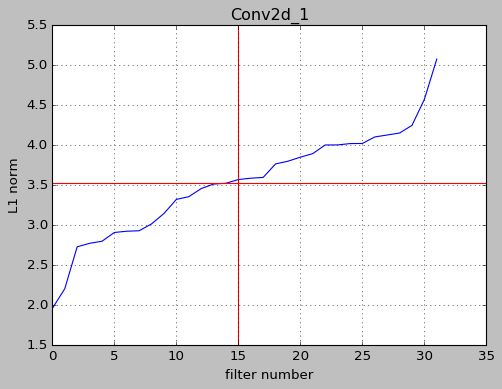

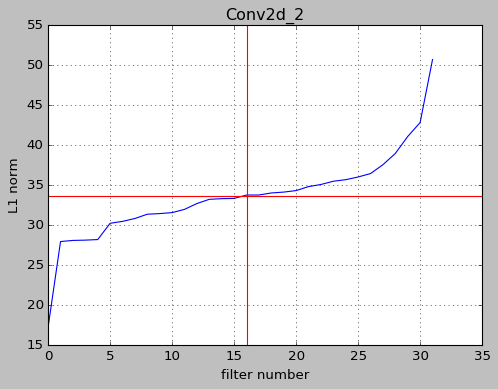

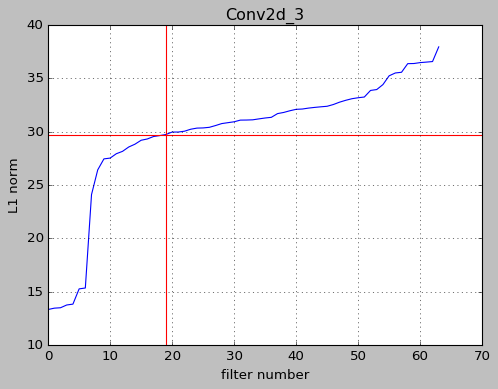

In [24]:
 my_in_conv_layers_get_L1_norms_sorted_indices_and_values(my_model,True)

In [25]:
def my_get_prune_filter_indices(model):
    layer_wise_filter_sorted_indices,layer_wise_filter_sorted_values = my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model,False)
    all_conv_layers = my_get_all_conv_layers(model)
    thresh_hold_means = list()
    for i in range(len(all_conv_layers)):
        thresh_hold_means.append(np.mean(np.array(layer_wise_filter_sorted_values[i])))
    prune_filter_indices = list()
    for i in range(len(all_conv_layers)):
        for j in range(len(layer_wise_filter_sorted_values[i])):
            if(thresh_hold_means[i] < layer_wise_filter_sorted_values[i][j]):
                prune_filter_indices.append(j)
                break
    return prune_filter_indices
prune_filter_indices = my_get_prune_filter_indices(my_model)
prune_filter_indices

[15, 16, 19]

In [0]:
def my_delete_filters(model):
    layer_wise_filter_sorted_indices,layer_wise_filter_sorted_values = my_in_conv_layers_get_L1_norms_sorted_indices_and_values(model,False)
    prune_filter_indices = my_get_prune_filter_indices(model)
    surgeon = Surgeon(my_model)
    for index,value in enumerate(all_conv_layers):
        surgeon.add_job('delete_channels',model.layers[value],channels = layer_wise_filter_sorted_indices[index][0:prune_filter_indices[index]])
    model_new = surgeon.operate()
    return model_new


In [27]:
# Run this cell if you don't have the weights saved
model_new = my_delete_filters(my_model)
model_new.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_new.save('drive/My Drive/ColabNotebooks/just_after_pruning.h5')

Deleting 15/32 channels from layer: conv2d_8
Deleting 16/32 channels from layer: conv2d_9
Deleting 19/64 channels from layer: conv2d_10


In [28]:
model_new = load_model('drive/My Drive/ColabNotebooks/just_after_pruning.h5')
model_new.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8_input (InputLayer)  (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 17)        476       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 17)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 16)        2464      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 45)          6525      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 45)          0   

In [29]:



score_train = model_new.evaluate(x_train,y_train) 

print('Accuracy on the Train Images: ', score_train[1])

score_test = model_new.evaluate(x_test, y_test)

print('Accuracy on the Test Images: ', score_test[1])


50000/50000 [==============================] - 17s 331us/step
Accuracy on the Train Images:  0.25366
10000/10000 [==============================] - 3s 315us/step
Accuracy on the Test Images:  0.2478


In [30]:
# Run this cell if you don't have the weights saved
model_new.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.2, shuffle=True)
model_new.save('drive/My Drive/Colab Notebooks/after_training_pruned_model.h5')

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 38s 944us/step - loss: 1.0916 - acc: 0.6148 - val_loss: 1.0713 - val_acc: 0.6251
Epoch 2/10
40000/40000 [==============================] - 38s 959us/step - loss: 0.9574 - acc: 0.6642 - val_loss: 1.0170 - val_acc: 0.6441
Epoch 3/10
40000/40000 [==============================] - 39s 965us/step - loss: 0.9136 - acc: 0.6803 - val_loss: 0.9626 - val_acc: 0.6658
Epoch 4/10
40000/40000 [==============================] - 40s 990us/step - loss: 0.8796 - acc: 0.6914 - val_loss: 0.9731 - val_acc: 0.6663
Epoch 5/10
40000/40000 [==============================] - 39s 968us/step - loss: 0.8549 - acc: 0.6996 - val_loss: 0.9537 - val_acc: 0.6701
Epoch 6/10
40000/40000 [==============================] - 39s 973us/step - loss: 0.8387 - acc: 0.7062 - val_loss: 0.9624 - val_acc: 0.6643
Epoch 7/10
40000/40000 [==============================] - 38s 961us/step - loss: 0.8260 - acc: 0.7097 - val_loss: 0.

In [34]:
model_new = load_model('drive/My Drive/Colab Notebooks/after_training_pruned_model.h5')

score_train = model_new.evaluate(x_train,y_train) 

print('Accuracy on the Train Images: ', score_train[1])

score_test = model_new.evaluate(x_test, y_test)

print('Accuracy on the Test Images: ', score_test[1])



50000/50000 [==============================] - 18s 354us/step
Accuracy on the Train Images:  0.72552
10000/10000 [==============================] - 4s 358us/step
Accuracy on the Test Images:  0.6757
